📁 Loaded dataset: (9240, 180)


2025/07/18 11:47:09 INFO mlflow.tracking.fluent: Experiment with name 'Sales_Conversion_Prediction' does not exist. Creating a new experiment.


🚀 Starting Sales Conversion Prediction Pipeline...
📊 Dataset: 9240 samples, 179 features
📈 Conversion rate: 38.54%

🔍 Training model: LogisticRegression
✅ LogisticRegression -> ROC-AUC: 0.9775, Accuracy: 0.9345, F1: 0.9141
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/162628025470566835/runs/df9904cb7b3d403b8d050a4a0933b9ac
🧪 View experiment at: http://localhost:5000/#/experiments/162628025470566835

🔍 Training model: RandomForest
✅ RandomForest -> ROC-AUC: 0.9807, Accuracy: 0.9345, F1: 0.9134
🏃 View run RandomForest at: http://localhost:5000/#/experiments/162628025470566835/runs/4b7bcc12b90f470a80449ddc1fca277b
🧪 View experiment at: http://localhost:5000/#/experiments/162628025470566835

🔍 Training model: LightGBM
✅ LightGBM -> ROC-AUC: 0.9834, Accuracy: 0.9497, F1: 0.9343
🏃 View run LightGBM at: http://localhost:5000/#/experiments/162628025470566835/runs/d4aa373f80ce46e2932e1ec2767bcbf9
🧪 View experiment at: http://localhost:5000/#/experiments/1626280254705668

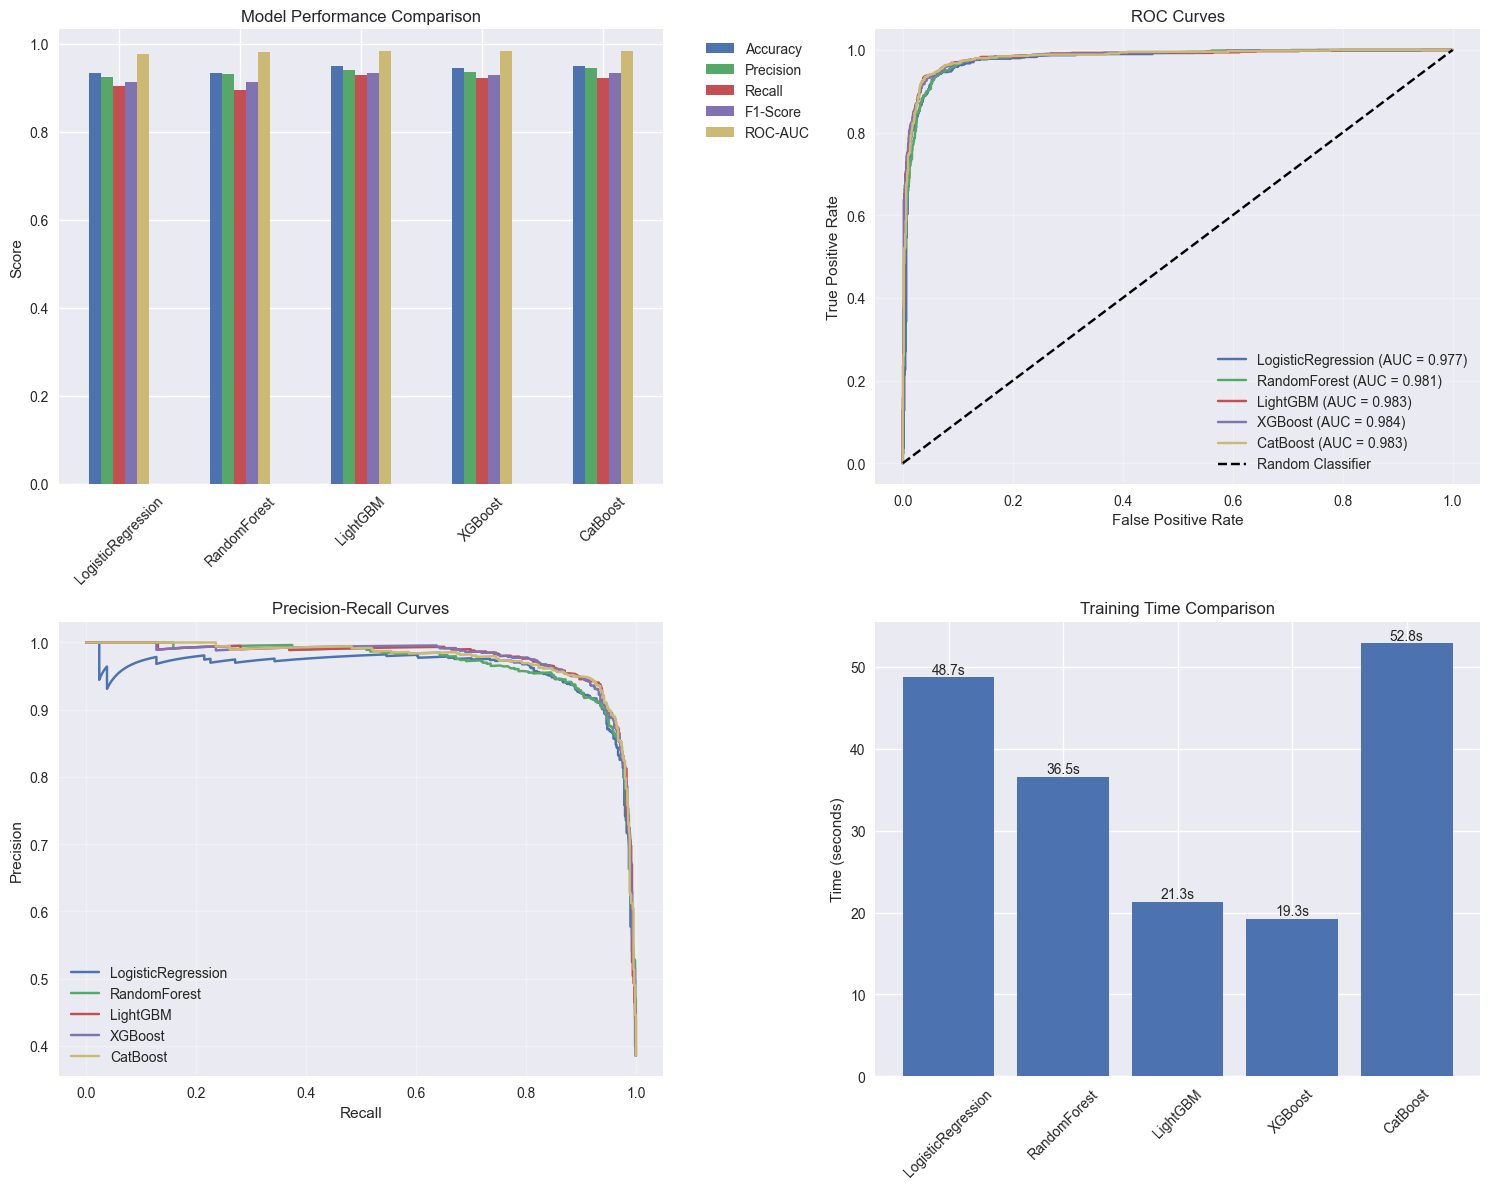


📦 Registering the best model: XGBoost (ROC-AUC: 0.9837)
🏃 View run selective-shark-711 at: http://localhost:5000/#/experiments/162628025470566835/runs/e773754b70a94852aea9dcaefe104d9f
🧪 View experiment at: http://localhost:5000/#/experiments/162628025470566835


2025/07/18 11:50:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 11:51:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Sales_Conversion_Prediction_Model_v2'.
2025/07/18 11:51:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Sales_Conversion_Prediction_Model_v2, version 1
Created version '1' of model 'Sales_Conversion_Prediction_Model_v2'.
2025/07/18 11:51:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Sales_Conversion_Prediction_Model_v2, version 2


✅ Registered and promoted model 'Sales_Conversion_Prediction_Model_v2' version 2 to Production

🎯 PIPELINE SUMMARY:
   • Best Model: XGBoost
   • ROC-AUC Score: 0.9837
   • Accuracy: 0.9459
   • Precision: 0.9359
   • Recall: 0.9228
   • F1-Score: 0.9293
   • Training Time: 19.26 seconds
   • Model URI: runs:/0761912f20d84702be4bcad6d5d18e27/model
   • Registry: Sales_Conversion_Prediction_Model_v2 v2
🏃 View run XGBoost_Register at: http://localhost:5000/#/experiments/162628025470566835/runs/0761912f20d84702be4bcad6d5d18e27
🧪 View experiment at: http://localhost:5000/#/experiments/162628025470566835

🏁 Pipeline completed successfully!
🎯 Results: {'model_name': 'Sales_Conversion_Prediction_Model_v2', 'version': '2', 'model_uri': 'runs:/0761912f20d84702be4bcad6d5d18e27/model', 'run_id': '0761912f20d84702be4bcad6d5d18e27', 'best_model_name': 'XGBoost', 'best_roc_auc': 0.9836980979981009, 'metrics': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsam

In [1]:
import os
import tempfile
import joblib
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
import mlflow.xgboost
import mlflow.catboost
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# ML: Models, training, and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException

# ===============================
# Step 1: Train/test split
# ===============================
def train_test_split_data(df, target_col='Converted', test_size=0.2, random_state=42):
    """Split data into train/test sets"""
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# ===============================
# Step 2: Define models and params
# ===============================
def get_models_and_params():
    """Define models and their hyperparameter grids"""
    models = {
        'LogisticRegression': (
            LogisticRegression(random_state=42, max_iter=1000),
            {
                'C': [0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }
        ),
        'RandomForest': (
            RandomForestClassifier(random_state=42, n_jobs=-1),
            {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        ),
        'LightGBM': (
            lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
            {
                'n_estimators': [100, 200],
                'max_depth': [6, 10],
                'learning_rate': [0.01, 0.1],
                'num_leaves': [31, 50]
            }
        ),
        'XGBoost': (
            xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
            {
                'n_estimators': [100, 200],
                'max_depth': [3, 6],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            }
        ),
        'CatBoost': (
            CatBoostClassifier(random_state=42, verbose=False, thread_count=-1),
            {
                'iterations': [100, 200],
                'depth': [4, 6],
                'learning_rate': [0.01, 0.1],
                'l2_leaf_reg': [1, 3]
            }
        )
    }
    return models

# ===============================
# Step 3: Model-specific MLflow loggers
# ===============================
def get_mlflow_logger(model_name):
    """Get appropriate MLflow logger for each model type"""
    loggers = {
        'LogisticRegression': mlflow.sklearn.log_model,
        'RandomForest': mlflow.sklearn.log_model,
        'LightGBM': mlflow.lightgbm.log_model,
        'XGBoost': mlflow.xgboost.log_model,
        'CatBoost': mlflow.catboost.log_model
    }
    return loggers.get(model_name, mlflow.sklearn.log_model)

# ===============================
# Step 4: Create visualizations
# ===============================
def create_and_log_visualizations(models_results, X_test, y_test, plots_dir="plots"):
    """Create comprehensive visualizations and log to MLflow"""
    os.makedirs(plots_dir, exist_ok=True)
    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Model Performance Comparison
    ax1 = axes[0, 0]
    metrics_df = pd.DataFrame({
        name: {
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1_score'],
            'ROC-AUC': result['roc_auc']
        } for name, result in models_results.items()
    }).T
    
    metrics_df.plot(kind='bar', ax=ax1)
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylabel('Score')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. ROC Curves
    ax2 = axes[0, 1]
    for name, result in models_results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc_score = result['roc_auc']
        ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
    
    ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    ax3 = axes[1, 0]
    for name, result in models_results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        ax3.plot(recall, precision, label=f'{name}')
    
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curves')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Training Time Comparison
    ax4 = axes[1, 1]
    training_times = [result['training_time'] for result in models_results.values()]
    model_names = list(models_results.keys())
    bars = ax4.bar(model_names, training_times)
    ax4.set_title('Training Time Comparison')
    ax4.set_ylabel('Time (seconds)')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, time in zip(bars, training_times):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{time:.1f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save and log plot
    plot_path = os.path.join(plots_dir, 'model_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    
    try:
        mlflow.log_artifact(plot_path)
        print(f"📊 Visualizations logged to MLflow: {plot_path}")
    except Exception as e:
        print(f"⚠️ Warning: Could not log plot to MLflow: {e}")
    
    plt.show()
    return plot_path

# ===============================
# Step 5: Train, log, and register best model
# ===============================
def run_pipeline_with_mlflow_and_register(df, model_registry_name="Sales_Conversion_Prediction_Model"):
    """Main pipeline: train models, track with MLflow, and register best model"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split_data(df)
    
    # Initialize tracking variables
    best_roc_auc = 0.0
    best_model = None
    best_model_name = ""
    best_params = {}
    best_run_id = None
    models_results = {}
    
    # Get models and parameters
    models = get_models_and_params()
    
    # Setup MLflow
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Sales_Conversion_Prediction")
    
    # End any existing run
    mlflow.end_run()
    
    print("🚀 Starting Sales Conversion Prediction Pipeline...")
    print(f"📊 Dataset: {len(df)} samples, {len(X_train.columns)} features")
    print(f"📈 Conversion rate: {y_train.mean():.2%}")
    
    # Train each model
    for name, (model, param_grid) in models.items():
        print(f"\n🔍 Training model: {name}")
        start_time = datetime.now()
        
        with mlflow.start_run(run_name=name) as run:
            # Hyperparameter tuning
            if param_grid:
                search = RandomizedSearchCV(
                    model, 
                    param_distributions=param_grid,  # Fixed: use param_distributions
                    cv=5, 
                    scoring='roc_auc', 
                    n_jobs=-1,
                    n_iter=10,
                    random_state=42
                )
                search.fit(X_train, y_train)
                best_estimator = search.best_estimator_
                best_params = search.best_params_
            else:
                model.fit(X_train, y_train)
                best_estimator = model
                best_params = {}
            
            # Make predictions
            y_pred = best_estimator.predict(X_test)
            y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            training_time = (datetime.now() - start_time).total_seconds()
            
            # Log parameters and metrics
            mlflow.log_param("model", name)
            mlflow.log_param("dataset_size", len(df))
            mlflow.log_param("num_features", len(X_train.columns))
            mlflow.log_param("conversion_rate", y_train.mean())
            
            for param, value in best_params.items():
                mlflow.log_param(param, value)
            
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("roc_auc", roc_auc)
            mlflow.log_metric("training_time", training_time)
            
            # Store results
            models_results[name] = {
                'model': best_estimator,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'training_time': training_time,
                'params': best_params
            }
            
            print(f"✅ {name} -> ROC-AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            
            # Track best model
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = best_estimator
                best_model_name = name
                best_run_id = run.info.run_id
    
    # Create and log visualizations
    print(f"\n📊 Creating visualizations...")
    plot_path = create_and_log_visualizations(models_results, X_test, y_test)
    
    # Register the best model
    print(f"\n📦 Registering the best model: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")
    
    # End any existing run before starting registration
    mlflow.end_run()
    
    with mlflow.start_run(run_name=f"{best_model_name}_Register") as reg_run:
        run_id = reg_run.info.run_id
        artifact_path = "model"
        
        # Log dataset info
        mlflow.log_param("best_model", best_model_name)
        mlflow.log_param("best_roc_auc", best_roc_auc)
        mlflow.log_param("dataset_size", len(df))
        mlflow.log_param("num_features", len(X_train.columns))
        
        # Log best model metrics
        best_result = models_results[best_model_name]
        mlflow.log_metric("best_accuracy", best_result['accuracy'])
        mlflow.log_metric("best_precision", best_result['precision'])
        mlflow.log_metric("best_recall", best_result['recall'])
        mlflow.log_metric("best_f1_score", best_result['f1_score'])
        mlflow.log_metric("best_roc_auc", best_result['roc_auc'])
        
        # Get appropriate logger and log model
        logger = get_mlflow_logger(best_model_name)
        logger(best_model, artifact_path, registered_model_name=model_registry_name)
        
        model_uri = f"runs:/{run_id}/{artifact_path}"
        client = MlflowClient()
        
        # Create registered model if it doesn't exist
        try:
            client.get_registered_model(model_registry_name)
        except MlflowException:
            client.create_registered_model(
                model_registry_name,
                description=f"Sales conversion prediction model using {best_model_name}"
            )
        
        # Create model version
        model_version = client.create_model_version(
            name=model_registry_name,
            source=model_uri,
            run_id=run_id,
            description=f"""
            Best performing sales conversion model: {best_model_name}
            
            Performance Metrics:
            - ROC-AUC: {best_roc_auc:.4f}
            - Accuracy: {best_result['accuracy']:.4f}
            - Precision: {best_result['precision']:.4f}
            - Recall: {best_result['recall']:.4f}
            - F1-Score: {best_result['f1_score']:.4f}
            
            Dataset: {len(df)} samples, {len(X_train.columns)} features
            Training time: {best_result['training_time']:.2f} seconds
            """
        ).version
        
        # Add tags
        client.set_model_version_tag(
            name=model_registry_name,
            version=model_version,
            key="algorithm",
            value=best_model_name
        )
        
        client.set_model_version_tag(
            name=model_registry_name,
            version=model_version,
            key="roc_auc",
            value=str(round(best_roc_auc, 4))
        )
        
        client.set_model_version_tag(
            name=model_registry_name,
            version=model_version,
            key="dataset_size",
            value=str(len(df))
        )
        
        # Transition to Production
        client.transition_model_version_stage(
            name=model_registry_name,
            version=model_version,
            stage="Production"
        )
        
        print(f"✅ Registered and promoted model '{model_registry_name}' version {model_version} to Production")
        
        # Save local copies
        with open("latest_model_uri.txt", "w") as f:
            f.write(model_uri)
        with open("latest_run_id.txt", "w") as f:
            f.write(run_id)
        
        # Print summary
        print(f"\n🎯 PIPELINE SUMMARY:")
        print(f"   • Best Model: {best_model_name}")
        print(f"   • ROC-AUC Score: {best_roc_auc:.4f}")
        print(f"   • Accuracy: {best_result['accuracy']:.4f}")
        print(f"   • Precision: {best_result['precision']:.4f}")
        print(f"   • Recall: {best_result['recall']:.4f}")
        print(f"   • F1-Score: {best_result['f1_score']:.4f}")
        print(f"   • Training Time: {best_result['training_time']:.2f} seconds")
        print(f"   • Model URI: {model_uri}")
        print(f"   • Registry: {model_registry_name} v{model_version}")
        
        return {
            "model_name": model_registry_name,
            "version": model_version,
            "model_uri": model_uri,
            "run_id": run_id,
            "best_model_name": best_model_name,
            "best_roc_auc": best_roc_auc,
            "metrics": best_result,
            "plot_path": plot_path
        }

# ===============================
# Step 6: Utility functions
# ===============================
def load_registered_model(model_name="Sales_Conversion_Prediction_Model", stage="Production"):
    """Load a registered model from MLflow Model Registry"""
    try:
        model_uri = f"models:/{model_name}/{stage}"
        loaded_model = mlflow.pyfunc.load_model(model_uri)
        
        print(f"✅ Model loaded successfully from MLflow Registry")
        print(f"   • Model: {model_name}")
        print(f"   • Stage: {stage}")
        print(f"   • URI: {model_uri}")
        
        return loaded_model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def get_model_info(model_name="Sales_Conversion_Prediction_Model"):
    """Get information about registered model"""
    try:
        client = MlflowClient()
        model = client.get_registered_model(model_name)
        versions = client.get_latest_versions(model_name)
        
        print(f"\n📋 MODEL INFO: {model_name}")
        print(f"   • Description: {model.description}")
        print(f"   • Created: {model.creation_timestamp}")
        print(f"   • Last Updated: {model.last_updated_timestamp}")
        
        print(f"\n📊 VERSIONS:")
        for version in versions:
            print(f"   • Version {version.version}: {version.current_stage}")
            print(f"     Status: {version.status}")
            
            # Get tags
            tags = client.get_model_version(model_name, version.version).tags
            if tags:
                print(f"     Tags: {dict(tags)}")
        
        return model
    except Exception as e:
        print(f"❌ Error getting model info: {e}")
        return None

def start_mlflow_ui():
    """Start MLflow UI"""
    import subprocess
    try:
        subprocess.Popen(["mlflow", "ui"])
        print("🚀 MLflow UI started at http://localhost:5000")
    except Exception as e:
        print(f"❌ Error starting MLflow UI: {e}")
        print("Please run 'mlflow ui' manually in your terminal")

# ===============================
# Step 7: Main execution
# ===============================
if __name__ == "__main__":
    # Load your data here
    try:
        # Update this path to your actual data file
        data_path = r'C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\preprocessed_data.csv'
        
        # Load data
        if 'df' not in locals():
            df = pd.read_csv(data_path)
            print(f"📁 Loaded dataset: {df.shape}")
        
        # Run pipeline
        result = run_pipeline_with_mlflow_and_register(
            df, 
            model_registry_name="Sales_Conversion_Prediction_Model_v2"
        )
        
        print(f"\n🏁 Pipeline completed successfully!")
        print(f"🎯 Results: {result}")
        
        # Show additional info
        print(f"\n🔗 MLFLOW COMMANDS:")
        print(f"   • Start UI: mlflow ui")
        print(f"   • View at: http://localhost:5000")
        print(f"   • Model Registry: http://localhost:5000/#/models")
        
        # Example of loading the registered model
        # loaded_model = load_registered_model("Sales_Conversion_Prediction_Model_v2")
        # get_model_info("Sales_Conversion_Prediction_Model_v2")
        
    except FileNotFoundError:
        print(f"❌ Error: Data file not found")
        print("Please update the data_path variable or ensure 'df' is loaded")
    except NameError:
        print("❌ Please ensure your DataFrame 'df' is loaded before running this script.")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

In [7]:
import pickle
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
from typing import Union, Dict, Any, Optional, Tuple
import logging

# MLflow imports
import mlflow
import mlflow.pyfunc
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class MLflowLeadConversionPipeline:
    """
    A pipeline for lead conversion prediction using MLflow production models.

    This class provides functionality to:
    - Load trained preprocessing pipeline and model from MLflow
    - Clean and preprocess incoming data
    - Align features as per the training phase
    - Perform predictions using MLflow production model
    - Save prediction results to a file
    """

    def __init__(self, 
                 pipeline_path: str, 
                 metadata_path: str, 
                 model_name: str = "Sales_Conversion_Prediction_Model_v2",
                 model_stage: str = "Production",
                 mlflow_tracking_uri: str = "http://localhost:5000"):
        """
        Initialize the pipeline by loading preprocessing components and MLflow model.

        Args:
            pipeline_path (str): Path to the preprocessing pipeline (.pkl file)
            metadata_path (str): Path to the metadata file (.pkl)
            model_name (str): Name of the registered model in MLflow
            model_stage (str): Stage of the model (Production, Staging, etc.)
            mlflow_tracking_uri (str): MLflow tracking server URI
        """
        self.pipeline_path = pipeline_path
        self.metadata_path = metadata_path
        self.model_name = model_name
        self.model_stage = model_stage
        self.mlflow_tracking_uri = mlflow_tracking_uri

        self.preprocessor = None
        self.metadata = None
        self.model = None
        self.model_info = None
        self.mlflow_client = None

        self._setup_mlflow()
        self._load_components()

    def _setup_mlflow(self) -> None:
        """Setup MLflow client and tracking URI."""
        try:
            mlflow.set_tracking_uri(self.mlflow_tracking_uri)
            self.mlflow_client = MlflowClient(tracking_uri=self.mlflow_tracking_uri)
            logger.info(f"MLflow client connected to: {self.mlflow_tracking_uri}")
        except Exception as e:
            logger.error(f"Error setting up MLflow: {e}")
            raise

    def _load_components(self) -> None:
        """Loads the preprocessing pipeline, metadata, and trained model from MLflow."""
        try:
            # Load preprocessing pipeline
            with open(self.pipeline_path, 'rb') as f:
                self.preprocessor = pickle.load(f)
            logger.info("Preprocessing pipeline loaded successfully")

            # Load metadata
            with open(self.metadata_path, 'rb') as f:
                self.metadata = pickle.load(f)
            logger.info("Metadata loaded successfully")

            # Load model from MLflow Model Registry
            self._load_mlflow_model()

        except Exception as e:
            logger.error(f"Error loading components: {e}")
            raise

    def _load_mlflow_model(self) -> None:
        """Load model from MLflow Model Registry."""
        try:
            # Get model info from registry
            model_version = self.mlflow_client.get_latest_versions(
                self.model_name, 
                stages=[self.model_stage]
            )
            
            if not model_version:
                raise ValueError(f"No model found in {self.model_stage} stage for {self.model_name}")
            
            model_version = model_version[0]
            
            # Load the model
            model_uri = f"models:/{self.model_name}/{self.model_stage}"
            self.model = mlflow.pyfunc.load_model(model_uri)
            
            # Get model information
            self.model_info = {
                'model_name': self.model_name,
                'model_version': model_version.version,
                'model_stage': model_version.current_stage,
                'model_uri': model_uri,
                'creation_timestamp': model_version.creation_timestamp,
                'last_updated_timestamp': model_version.last_updated_timestamp,
                'description': model_version.description
            }
            
            # Get model tags
            model_tags = self.mlflow_client.get_model_version(
                self.model_name, 
                model_version.version
            ).tags
            
            self.model_info['tags'] = model_tags
            
            logger.info(f"MLflow model loaded successfully:")
            logger.info(f"  - Model: {self.model_name}")
            logger.info(f"  - Version: {model_version.version}")
            logger.info(f"  - Stage: {model_version.current_stage}")
            logger.info(f"  - Algorithm: {model_tags.get('algorithm', 'Unknown')}")
            logger.info(f"  - ROC-AUC: {model_tags.get('roc_auc', 'Unknown')}")
            
        except Exception as e:
            logger.error(f"Error loading MLflow model: {e}")
            raise

    def _clean_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Cleans the input DataFrame to correct data types and missing values."""
        df_clean = df.copy()
        numerical_cols = self.metadata['numerical_features']
        categorical_cols = self.metadata['categorical_features']

        # Clean numerical columns
        for col in numerical_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col].astype(str), errors='coerce')
                if df_clean[col].isna().sum() > 0:
                    median_val = df_clean[col].median()
                    df_clean[col].fillna(median_val if not pd.isna(median_val) else 0, inplace=True)

        # Clean categorical columns
        for col in categorical_cols:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].astype(str).replace(['nan', 'None', 'null'], 'Unknown').str.strip()

        return df_clean

    def _encode_binary_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Encodes binary categorical values into numerical format."""
        df_encoded = df.copy()
        binary_cols = self.metadata['binary_features']

        for col in binary_cols:
            if col in df_encoded.columns:
                df_encoded[col] = df_encoded[col].astype(str).str.strip().str.lower()
                binary_mapping = {
                    'yes': 1, 'y': 1, '1': 1, 'true': 1, 'on': 1,
                    'no': 0, 'n': 0, '0': 0, 'false': 0, 'off': 0,
                    'unknown': 0, 'nan': 0, 'none': 0
                }
                df_encoded[f'{col}_encoded'] = df_encoded[col].map(binary_mapping).fillna(0).astype(int)

        return df_encoded

    def _align_features(self, X: pd.DataFrame) -> pd.DataFrame:
        """Aligns feature columns to match those used in model training."""
        try:
            # Try to get feature names from the model
            expected_features = self.model._model_impl.python_model.context.artifacts.get('feature_names')
            
            if expected_features is None:
                # Fallback: try to infer from model
                logger.warning("Could not get feature names from model, using existing features")
                return X
            
            # Create aligned DataFrame
            X_aligned = pd.DataFrame(0, index=X.index, columns=expected_features)
            
            # Fill in available features
            for col in X.columns:
                if col in expected_features:
                    X_aligned[col] = X[col]
            
            return X_aligned
            
        except Exception as e:
            logger.warning(f"Feature alignment failed: {e}. Using original features.")
            return X

    def preprocess_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """Runs the entire preprocessing pipeline on the input data."""
        df_processed = df.copy()
        actual_labels = None

        # Extract actual labels if present
        if 'Converted' in df_processed.columns:
            actual_labels = df_processed['Converted']
            df_processed.drop(columns=['Converted'], inplace=True)

        # Clean data types
        df_processed = self._clean_data_types(df_processed)
        
        # Encode binary features
        df_processed = self._encode_binary_features(df_processed)

        # Get feature columns
        numerical_cols = self.metadata['numerical_features']
        categorical_cols = self.metadata['categorical_features']
        binary_cols = self.metadata['binary_features']

        # Filter available columns
        available_num_cols = [col for col in numerical_cols if col in df_processed.columns]
        available_cat_cols = [col for col in categorical_cols if col in df_processed.columns]

        if available_num_cols or available_cat_cols:
            # Transform using preprocessor
            X_sample = df_processed[available_num_cols + available_cat_cols]
            X_transformed = self.preprocessor.transform(X_sample)

            # Get feature names
            try:
                feature_names = self.preprocessor.get_feature_names_out()
            except:
                feature_names = [f"feature_{i}" for i in range(X_transformed.shape[1])]

            # Create DataFrame with transformed features
            X_final = pd.DataFrame(X_transformed, columns=feature_names, index=df_processed.index)

            # Add encoded binary features
            for col in [f"{col}_encoded" for col in binary_cols if col in df.columns]:
                if col in df_processed.columns:
                    X_final[col] = df_processed[col].values

            # Align features
            X_final = self._align_features(X_final)
            
            return X_final, actual_labels

        else:
            raise ValueError("No valid numerical or categorical columns found for preprocessing")

    def predict(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Generates predictions for the given input data using MLflow model."""
        try:
            # Preprocess data
            X_final, actual_labels = self.preprocess_data(df)
            
            # Make predictions using MLflow model
            predictions = self.model.predict(X_final)
            
            # Try to get probabilities
            probabilities = None
            try:
                # For MLflow pyfunc models, we need to access the underlying model
                if hasattr(self.model, '_model_impl'):
                    underlying_model = self.model._model_impl.python_model
                    if hasattr(underlying_model, 'predict_proba'):
                        probabilities = underlying_model.predict_proba(X_final)
                    elif hasattr(underlying_model, '_model'):
                        if hasattr(underlying_model._model, 'predict_proba'):
                            probabilities = underlying_model._model.predict_proba(X_final)
            except Exception as e:
                logger.warning(f"Could not get probabilities: {e}")
                probabilities = None

            # Prepare results
            results = {
                'predictions': predictions,
                'probabilities': probabilities,
                'actual_labels': actual_labels,
                'input_data': df.copy(),
                'model_info': self.model_info
            }

            # Calculate accuracy if actual labels are available
            if actual_labels is not None:
                accuracy = (predictions == actual_labels).mean() * 100
                results['accuracy'] = accuracy

            return results
            
        except Exception as e:
            logger.error(f"Error during prediction: {e}")
            raise

    def predict_from_file(self, file_path: str, output_path: Optional[str] = None) -> Dict[str, Any]:
        """Reads data from a CSV file, makes predictions, and optionally saves results to CSV."""
        try:
            # Read input data
            df = pd.read_csv(file_path)
            logger.info(f"Loaded {len(df)} samples from {file_path}")
            
            # Make predictions
            results = self.predict(df)
            
            # Prepare results DataFrame
            results_df = results['input_data'].copy()
            results_df['Predicted_Converted'] = results['predictions']
            
            # Add probabilities if available
            if results['probabilities'] is not None:
                prob_df = pd.DataFrame(
                    results['probabilities'],
                    columns=[f'Prob_Class_{i}' for i in range(results['probabilities'].shape[1])],
                    index=results_df.index
                )
                results_df = pd.concat([results_df, prob_df], axis=1)
            
            # Add actual labels and correctness if available
            if results['actual_labels'] is not None:
                results_df['Actual_Converted'] = results['actual_labels']
                results_df['Prediction_Correct'] = (
                    results_df['Predicted_Converted'] == results_df['Actual_Converted']
                )
            
            # Save results if output path is provided
            if output_path:
                results_df.to_csv(output_path, index=False)
                logger.info(f"Results saved to {output_path}")
            
            results['results_df'] = results_df
            return results
            
        except Exception as e:
            logger.error(f"Error processing file: {e}")
            raise

    def get_model_info(self) -> Dict[str, Any]:
        """Returns comprehensive information about the loaded model."""
        info = {
            'mlflow_model_info': self.model_info,
            'preprocessing_info': {
                'numerical_features': self.metadata['numerical_features'],
                'categorical_features': self.metadata['categorical_features'],
                'binary_features': self.metadata['binary_features']
            }
        }
        
        return info

    def get_available_models(self) -> Dict[str, Any]:
        """Get information about all available models in MLflow registry."""
        try:
            registered_models = self.mlflow_client.list_registered_models()
            
            models_info = {}
            for model in registered_models:
                versions = self.mlflow_client.get_latest_versions(model.name)
                models_info[model.name] = {
                    'description': model.description,
                    'creation_timestamp': model.creation_timestamp,
                    'last_updated_timestamp': model.last_updated_timestamp,
                    'versions': [
                        {
                            'version': v.version,
                            'stage': v.current_stage,
                            'status': v.status,
                            'creation_timestamp': v.creation_timestamp
                        }
                        for v in versions
                    ]
                }
            
            return models_info
            
        except Exception as e:
            logger.error(f"Error getting available models: {e}")
            return {}

    def switch_model_stage(self, stage: str) -> None:
        """Switch to a different model stage (Production, Staging, etc.)."""
        try:
            self.model_stage = stage
            self._load_mlflow_model()
            logger.info(f"Successfully switched to {stage} stage")
        except Exception as e:
            logger.error(f"Error switching model stage: {e}")
            raise

# Utility Functions
def create_mlflow_pipeline(pipeline_path: str, 
                          metadata_path: str, 
                          model_name: str = "Sales_Conversion_Prediction_Model_v2",
                          model_stage: str = "Production",
                          mlflow_tracking_uri: str = "http://localhost:5000") -> MLflowLeadConversionPipeline:
    """Instantiates the MLflowLeadConversionPipeline class."""
    return MLflowLeadConversionPipeline(
        pipeline_path, 
        metadata_path, 
        model_name, 
        model_stage, 
        mlflow_tracking_uri
    )

def predict_from_csv_mlflow(pipeline_path: str, 
                           metadata_path: str, 
                           input_csv: str, 
                           output_csv: str = None,
                           model_name: str = "Sales_Conversion_Prediction_Model_v2",
                           model_stage: str = "Production",
                           mlflow_tracking_uri: str = "http://localhost:5000") -> Dict[str, Any]:
    """Convenience function to predict using MLflow model and input CSV file."""
    pipeline = create_mlflow_pipeline(
        pipeline_path, 
        metadata_path, 
        model_name, 
        model_stage, 
        mlflow_tracking_uri
    )
    return pipeline.predict_from_file(input_csv, output_csv)

def list_available_models(mlflow_tracking_uri: str = "http://localhost:5000") -> None:
    """List all available models in MLflow registry."""
    try:
        mlflow.set_tracking_uri(mlflow_tracking_uri)
        client = MlflowClient(tracking_uri=mlflow_tracking_uri)
        
        models = client.list_registered_models()
        
        print("🏷️ AVAILABLE MODELS IN MLFLOW REGISTRY:")
        print("=" * 60)
        
        for model in models:
            print(f"\n📦 Model: {model.name}")
            print(f"   Description: {model.description}")
            print(f"   Created: {model.creation_timestamp}")
            
            # Get versions
            versions = client.get_latest_versions(model.name)
            print(f"   📊 Versions:")
            for version in versions:
                tags = client.get_model_version(model.name, version.version).tags
                print(f"     • Version {version.version}: {version.current_stage}")
                print(f"       Status: {version.status}")
                if tags:
                    print(f"       Tags: {dict(tags)}")
        
    except Exception as e:
        print(f"❌ Error listing models: {e}")

if __name__ == "__main__":
    warnings.filterwarnings('ignore')

    # Configuration
    PIPELINE_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\pipeline_model.pkl"
    METADATA_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\metadata.pkl"
    INPUT_CSV = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\raw_data\check.csv"
    OUTPUT_CSV = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\prediction_results_mlflow.csv"
    
    # MLflow configuration
    MODEL_NAME = "Sales_Conversion_Prediction_Model_v2"
    MODEL_STAGE = "Production"
    MLFLOW_TRACKING_URI = "http://localhost:5000"
    
    try:
        print("🚀 Starting MLflow Lead Conversion Prediction Pipeline...")
        print("=" * 70)
        
        # List available models
        print("🔍 Checking available models...")
        list_available_models(MLFLOW_TRACKING_URI)
        
        # Option 1: Use convenience function
        print(f"\n📊 Making predictions using MLflow model...")
        results = predict_from_csv_mlflow(
            PIPELINE_PATH, 
            METADATA_PATH, 
            INPUT_CSV, 
            OUTPUT_CSV,
            MODEL_NAME,
            MODEL_STAGE,
            MLFLOW_TRACKING_URI
        )
        
        # Option 2: Use the class directly for more control
        print(f"\n🔧 Using pipeline class for detailed analysis...")
        pipeline = create_mlflow_pipeline(
            PIPELINE_PATH, 
            METADATA_PATH, 
            MODEL_NAME, 
            MODEL_STAGE, 
            MLFLOW_TRACKING_URI
        )
        
        # Get model information
        model_info = pipeline.get_model_info()
        mlflow_info = model_info['mlflow_model_info']
        
        print(f"\n📋 MODEL INFORMATION:")
        print(f"   • Model Name: {mlflow_info['model_name']}")
        print(f"   • Model Version: {mlflow_info['model_version']}")
        print(f"   • Model Stage: {mlflow_info['model_stage']}")
        print(f"   • Algorithm: {mlflow_info['tags'].get('algorithm', 'Unknown')}")
        print(f"   • ROC-AUC: {mlflow_info['tags'].get('roc_auc', 'Unknown')}")
        print(f"   • Dataset Size: {mlflow_info['tags'].get('dataset_size', 'Unknown')}")
        
        # Make predictions
        results = pipeline.predict_from_file(INPUT_CSV, OUTPUT_CSV)
        
        print(f"\n📊 PREDICTION SUMMARY:")
        print(f"   • Total samples: {len(results['predictions'])}")
        print(f"   • Predictions: {pd.Series(results['predictions']).value_counts().to_dict()}")
        if 'accuracy' in results:
            print(f"   • Accuracy: {results['accuracy']:.2f}%")
        
        # Show sample predictions
        if len(results['results_df']) > 0:
            print(f"\n📋 SAMPLE PREDICTIONS:")
            sample_df = results['results_df'].head(5)
            print(sample_df[['Predicted_Converted'] + 
                           ([col for col in sample_df.columns if col.startswith('Prob_Class_')])].to_string(index=False))
        
        print(f"\n✅ Prediction pipeline completed successfully!")
        print(f"📁 Results saved to: {OUTPUT_CSV}")
        
        # Example of switching model stage
        # pipeline.switch_model_stage("Staging")
        
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        print("Please check your file paths and ensure all required files exist.")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("Please check your MLflow server is running and model is registered.")
        print("Commands to check:")
        print("  • mlflow ui")
        print("  • Visit http://localhost:5000 to verify model registry")

2025-07-17 22:52:12,577 - INFO - MLflow client connected to: http://localhost:5000
2025-07-17 22:52:12,581 - INFO - Preprocessing pipeline loaded successfully
2025-07-17 22:52:12,583 - INFO - Metadata loaded successfully


🚀 Starting MLflow Lead Conversion Prediction Pipeline...
🔍 Checking available models...
❌ Error listing models: 'MlflowClient' object has no attribute 'list_registered_models'

📊 Making predictions using MLflow model...


2025-07-17 22:56:26,473 - INFO - MLflow model loaded successfully:
2025-07-17 22:56:26,474 - INFO -   - Model: Sales_Conversion_Prediction_Model_v2
2025-07-17 22:56:26,474 - INFO -   - Version: 2
2025-07-17 22:56:26,474 - INFO -   - Stage: Production
2025-07-17 22:56:26,475 - INFO -   - Algorithm: XGBoost
2025-07-17 22:56:26,475 - INFO -   - ROC-AUC: 0.9837
2025-07-17 22:56:26,506 - INFO - Loaded 5 samples from C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\raw_data\check.csv
2025-07-17 22:56:26,576 - WARNING - Feature alignment failed: '_XGBModelWrapper' object has no attribute 'python_model'. Using original features.
2025-07-17 22:56:26,592 - ERROR - Error during prediction: feature_names mismatch: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)', 'Tags_Graduation in progress', 'Tags_In confusion whether part time or DL

❌ Error: feature_names mismatch: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)', 'Tags_Graduation in progress', 'Tags_In confusion whether part time or DLP', 'Tags_Interested  in full time MBA', 'Tags_Interested in Next batch', 'Tags_Interested in other courses', 'Tags_Lateral student', 'Tags_Lost to EINS', 'Tags_Lost to Others', 'Tags_Not doing further education', 'Tags_Recognition issue (DEC approval)', 'Tags_Ringing', 'Tags_Shall take in the next coming month', 'Tags_Still Thinking', 'Tags_University not recognized', 'Tags_Want to take admission but has financial problems', 'Tags_Will revert after reading the email', 'Tags_in touch with EINS', 'Tags_invalid number', 'Tags_number not provided', 'Tags_opp hangup', 'Tags_switched off', 'Tags_wrong number given', 'Lead Quality_Low in Relevance', 'Lead Quality_Might be', 'Lead Q